In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

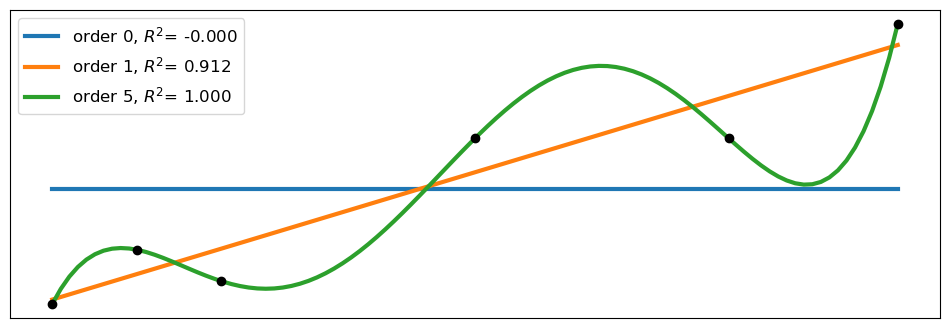

In [2]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])

order = [0, 1, 5]
ax.plot(x0, y0, "ko", zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat - y0) ** 2)
    ss_total = np.sum((ybar - y0) ** 2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)


ax.legend(loc=2, fontsize=12)
plt.savefig("../fig/over_under_fit.png")

In [4]:
order = 5 
x_p = np.vstack([x0**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y0 - y0.mean()) / y0.std()

In [5]:
with pm.Model() as model_l:
    α = pm.Normal("α", mu=0, sigma=.2)
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.Exponential("σ", 1)

    μ = α + β * x_c[0]

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    #idata_l.extend(pm.sample_posterior_predictive(idata_l, random_seed=4591))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


In [6]:
az.summary(idata_l, var_names=["~y_pred"])

c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\utils.py:134: UserWarning: Items starting with ~: ['y_pred'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.002,0.129,-0.244,0.247,0.002,0.002,5715.0,4983.0,1.0
β,0.918,0.196,0.560,1.272,0.003,0.002,4506.0,3246.0,1.0
σ,0.444,0.193,0.188,0.772,0.004,0.003,3309.0,3744.0,1.0


c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


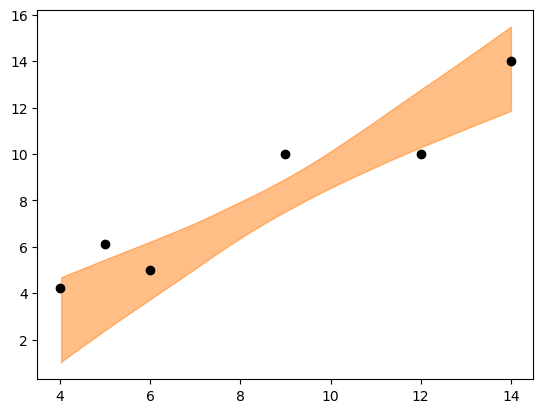

In [72]:
import xarray as xr
l_samps = az.extract(idata_l)
x_plot = np.linspace(np.min(x0), np.max(x0), 100)
x_plot_c = xr.DataArray((x_plot - x_plot.mean()) / x_plot.std())

y_plot = (l_samps['α'] + l_samps['β']* x_plot_c)*y0.std() + y0.mean()
az.plot_hdi(x_plot, y_plot, hdi_prob=.89, fill_kwargs={"alpha": .5})
plt.plot(x0, y0, "ko")  

In [41]:

order = 5
with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=.2)
    β = pm.Normal("β", mu=0, sigma=1, shape=order)
    σ = pm.Exponential("σ",1)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, target_accept = 0.95, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    #idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [45]:
az.summary(idata_q, var_names=["~y_pred"])

c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\utils.py:134: UserWarning: Items starting with ~: ['y_pred'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.000,0.138,-0.246,0.279,0.002,0.002,5788.0,4592.0,1.0
β[0],0.523,0.686,-0.790,1.809,0.009,0.007,5852.0,5336.0,1.0
β[1],0.222,0.863,-1.356,1.889,0.011,0.010,6119.0,5305.0,1.0
β[2],0.091,0.916,-1.670,1.768,0.012,0.011,5607.0,4900.0,1.0
β[3],0.034,0.839,-1.517,1.623,0.011,0.009,5414.0,5509.0,1.0
β[4],0.075,0.729,-1.326,1.389,0.010,0.008,5171.0,4710.0,1.0
σ,0.502,0.219,0.187,0.874,0.004,0.003,3842.0,3716.0,1.0


Overfitting manifests as large parameter uncertainties

In [46]:
import xarray as xr
q_samps = az.extract(idata_q)
x_plot = np.linspace(np.min(x0), np.max(x0), 100)
x_plot_p = xr.DataArray(np.vstack([x_plot**i for i in range(1, order + 1)]), dims = ['β_dim_0','x_dim_0'])
x_plot_c = (x_plot_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)

y_plot = (q_samps['α'] + xr.dot(q_samps['β'], x_plot_c))*y0.std() + y0.mean()

c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


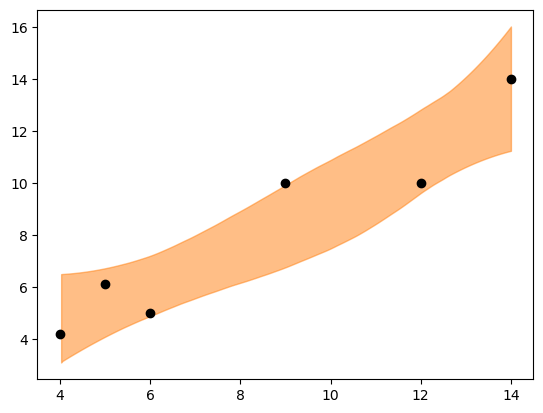

In [47]:
az.plot_hdi(x_plot, y_plot, hdi_prob=.89, fill_kwargs={"alpha": .5})
plt.plot(x0, y0, "ko")  

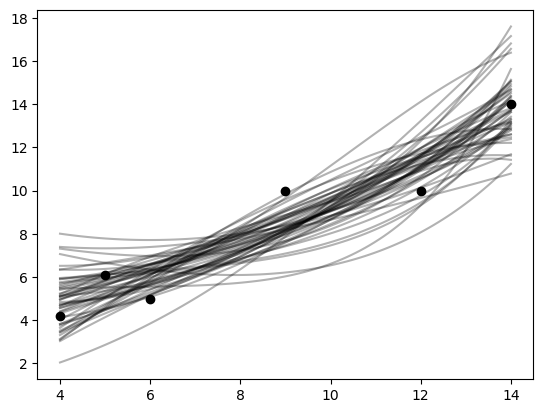

In [52]:
# plot 50 sample regression lines
for i in range(50):
    plt.plot(x_plot, (q_samps['α'][i] + xr.dot(q_samps['β'].isel(sample = i), x_plot_c))*y0.std() + y0.mean(), "k", alpha=.3)

plt.plot(x0, y0, "ko")  

In [53]:
# Compare the two models using pLoo:
loo_l = az.loo(idata_l)
loo_q = az.loo(idata_q)
az.compare({"linear": idata_l, "quadratic": idata_q})

c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\rjljr\miniconda3\envs\bap3\Lib\site-packages\arviz\

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear,0,-3.967674,1.657183,0.000000,1.0,0.644186,0.000000,False,log
quadratic,1,-5.384496,2.550258,1.416823,0.0,0.898484,0.835387,True,log


So the linear is better, but not sure it qualifies as overfitting.